In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# data is from: https://grouplens.org/datasets/movielens/

!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

!unzip -n ml-20m.zip

df = pd.read_csv('ml-20m/ratings.csv')
df.head()

--2022-04-23 19:02:49--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  53.9MB/s    in 3.9s    

2022-04-23 19:02:53 (49.1 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [3]:
# We can't trust the userId and movieId to be numbered 0...N-1. We will encode the two columns properly. 

df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [4]:
# Get user IDs, movie IDs, and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values


In [5]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

In [6]:
# Set embedding dimension
K = 10

In [7]:
# Make a neural network

# User input
u = Input(shape=(1,))

# Movie input
m = Input(shape=(1,))

# User embedding
u_emb = Embedding(N, K)(u) # output is (num_samples, 1, K)

# Movie embedding
m_emb = Embedding(M, K)(m) # output is (num_samples, 1, K)

# Flatten both embeddings
u_emb = Flatten()(u_emb) # now it's (num_samples, K)
m_emb = Flatten()(m_emb) # now it's (num_samples, K)

# Concatenate user-movie embeddings into a feature vector
x = Concatenate()([u_emb, m_emb]) # now it's (num_samples, 2K)

# Now that we have a feature vector, it's just a regular ANN
x = Dense(1024, activation='relu')(x)
# x = Dense(400, activation='relu')(x)
# x = Dense(400, activation='relu')(x)
x = Dense(1)(x)

In [8]:
# Build the model and compile
model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  optimizer=SGD(learning_rate=0.08, momentum=0.9),
)

In [9]:
# split the data
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)
Ntrain = int(0.8 * len(ratings))
train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_movie = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

In [10]:
# center the ratings
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating

In [11]:
r = model.fit(
  x=[train_user, train_movie],
  y=train_ratings,
  epochs=25,
  batch_size=1024,
  verbose=2, # goes a little faster when you don't print the progress bar
  validation_data=([test_user, test_movie], test_ratings),
)


Epoch 1/25
15626/15626 - 63s - loss: 0.7772 - val_loss: 0.7235 - 63s/epoch - 4ms/step
Epoch 2/25
15626/15626 - 50s - loss: 0.7011 - val_loss: 0.6975 - 50s/epoch - 3ms/step
Epoch 3/25
15626/15626 - 53s - loss: 0.6776 - val_loss: 0.6828 - 53s/epoch - 3ms/step
Epoch 4/25
15626/15626 - 53s - loss: 0.6628 - val_loss: 0.6763 - 53s/epoch - 3ms/step
Epoch 5/25
15626/15626 - 49s - loss: 0.6540 - val_loss: 0.6718 - 49s/epoch - 3ms/step
Epoch 6/25
15626/15626 - 53s - loss: 0.6451 - val_loss: 0.6624 - 53s/epoch - 3ms/step
Epoch 7/25
15626/15626 - 52s - loss: 0.6277 - val_loss: 0.6511 - 52s/epoch - 3ms/step
Epoch 8/25
15626/15626 - 49s - loss: 0.6122 - val_loss: 0.6481 - 49s/epoch - 3ms/step
Epoch 9/25
15626/15626 - 52s - loss: 0.6017 - val_loss: 0.6417 - 52s/epoch - 3ms/step
Epoch 10/25
15626/15626 - 53s - loss: 0.5928 - val_loss: 0.6404 - 53s/epoch - 3ms/step
Epoch 11/25
15626/15626 - 48s - loss: 0.5845 - val_loss: 0.6359 - 48s/epoch - 3ms/step
Epoch 12/25
15626/15626 - 52s - loss: 0.5763 - val_l

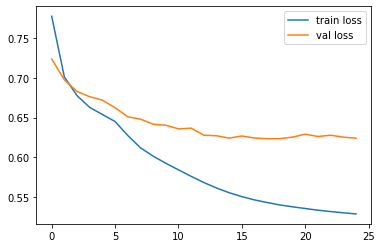

In [12]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="val loss")
plt.legend()
plt.show()

In [13]:
# Suppose we want to find recommendations for user_id = 1
# First find all the movie_ids for movies they haven't yet watched
watched_movie_ids = df[df.new_user_id == 1].new_movie_id.values

watched_movie_ids

potential_movie_ids = df[~df.new_movie_id.isin(watched_movie_ids)].new_movie_id.unique()

In [14]:
# How many?
potential_movie_ids.shape

(26683,)

In [15]:
# Repeat the user id this many times
user_id_to_recommend = np.ones_like(potential_movie_ids)

In [16]:
# Get predictions
predictions = model.predict([user_id_to_recommend, potential_movie_ids])

In [17]:
predictions.shape

(26683, 1)

In [18]:
# Get sort index for predictions
sort_idx = np.argsort(-predictions.flatten())


In [19]:
# Top 10 predictions
top_10_movie_ids = potential_movie_ids[sort_idx[:10]]
top_10_scores = predictions[sort_idx[:10]]

for movie, score in zip(top_10_movie_ids, top_10_scores):
  print("movie:", movie, "score:", score)

movie: 1017 score: [1.6974587]
movie: 1212 score: [1.6682127]
movie: 1173 score: [1.5941154]
movie: 453 score: [1.5823896]
movie: 376 score: [1.5524961]
movie: 8548 score: [1.5516162]
movie: 4234 score: [1.5512465]
movie: 843 score: [1.5506332]
movie: 1176 score: [1.537818]
movie: 4759 score: [1.5322783]
